In [307]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from keras import layers
import datetime
import math

In [308]:
# Load data from raw_data
feat = np.load(f'../raw_data/processed_data/feature/1.npy', allow_pickle=True)
y = np.load(f'../raw_data/processed_data/Y_train/1.npy')
date = pd.read_csv(f'../raw_data/processed_data/date/1.csv')

In [309]:
print(feat.shape)
print(y.shape)
print(date.shape)

(2, 124, 4, 81, 81)
(124, 4, 51, 51)
(124, 1)


In [310]:
tot= 24 # first 6 days
GHI=feat[0,:tot,:,:,:]
CLS=feat[1,:tot,:,:,:]
y=y[:tot,:,:,:]
DATE=date.iloc[:tot,:]
DATE['Datetime']=pd.to_datetime(DATE['Datetime'])

/tmp/ipykernel_12238/3490595328.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [320]:
df = pd.DataFrame({"time":pd.date_range(start='05:30', end='17:30', freq='15min')[:-1]})
df["x"]=np.linspace(0, 12 * 4 - 1, 12 * 4, dtype=int)

# We normalize x values to match with the 0-2π cycle
df["x_norm"] = 2 * math.pi * df["x"] / df["x"].max()

df["cos_x"] = np.cos(df["x_norm"])
df["sin_x"] = np.sin(df["x_norm"])

display(df.head(32))

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.x_norm, y=df.cos_x, name='cos_x'))
fig.add_trace(go.Scatter(x=df.x_norm, y=df.sin_x, name='sin_x'))

fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1))

fig.show()

,time,x,x_norm,cos_x,sin_x
0,2022-12-11 05:30:00,0,0.000000,1.000000,0.000000
1,2022-12-11 05:45:00,1,0.133685,0.991077,0.133287
2,2022-12-11 06:00:00,2,0.267370,0.964469,0.264195
3,2022-12-11 06:15:00,3,0.401054,0.920650,0.390389
4,2022-12-11 06:30:00,4,0.534739,0.860402,0.509617
5,2022-12-11 06:45:00,5,0.668424,0.784799,0.619750
6,2022-12-11 07:00:00,6,0.802109,0.695192,0.718824
7,2022-12-11 07:15:00,7,0.935794,0.593180,0.805070
8,2022-12-11 07:30:00,8,1.069478,0.480582,0.876950
9,2022-12-11 07:45:00,9,1.203163,0.359408,0.933181


In [312]:
print(GHI.shape)
print(y.shape)

(24, 4, 81, 81)
(24, 4, 51, 51)


In [313]:
number_of_obs=16 # 4 days for train and 2 days for validation
number_of_timestamp_per_obs=4
image_width=51
image_heigt=51
number_of_features=4
delta=datetime.timedelta(minutes=15)
hour=datetime.timedelta(minutes=45)

X_train=np.zeros((number_of_obs,number_of_timestamp_per_obs,image_width,image_heigt,number_of_features))
y_train=np.zeros((number_of_obs,number_of_timestamp_per_obs,image_width,image_heigt,number_of_features))
X_val=np.zeros((tot-number_of_obs,number_of_timestamp_per_obs,image_width,image_heigt,number_of_features))
y_val=np.zeros((tot-number_of_obs,number_of_timestamp_per_obs,image_width,image_heigt,number_of_features))

In [314]:
#Building X train and y train

for j in range (number_of_obs):
    for i in range (number_of_timestamp_per_obs):
        actual_time=(DATE['Datetime'][j]-hour+delta*i).time()
        #print (actual_time)
        for index, row in df.iterrows():
            if actual_time == df['time'][index].time():
                actual_index=index 
        for k in range (image_width):
            for h in range (image_heigt):
                for z in range (number_of_features):
                    if z==0:
                        X_train[j,i,k,h,z]=GHI[j,i,k+15,h+15]
                        y_train[j,i,k,h,z]=y[j,i,k,h]
                    if z==1:
                        X_train[j,i,k,h,z]=CLS[j,i,k+15,h+15]
                    if z==2: # Day_cosine
                        X_train[j,i,k,h,z]=df.iloc[actual_index,3]
                    if z==3: # Day_sine
                        X_train[j,i,k,h,z]=df.iloc[actual_index,4]
                                                     

In [315]:
#Building X val and y val  

for j in range (tot-number_of_obs):
    for i in range (number_of_timestamp_per_obs):
        actual_time=(DATE['Datetime'][j]-hour+delta*i).time()
        #print (actual_time)
        for index, row in df.iterrows():
            if actual_time == df['time'][index].time():
                actual_index=index 
        for k in range (image_width):
            for h in range (image_heigt):
                for z in range (number_of_features):
                    if z==0:
                        X_val[j,i,k,h,z]=GHI[j+number_of_obs,i,k+15,h+15]
                        y_val[j,i,k,h,z]=y[j+number_of_obs,i,k,h]
                    if z==1:
                        X_val[j,i,k,h,z]=CLS[j+number_of_obs,i,k+15,h+15]
                    if z==2: # Day_cosine
                        X_val[j,i,k,h,z]=df.iloc[actual_index,3]
                    if z==3: # Day_sine
                        X_val[j,i,k,h,z]=df.iloc[actual_index,4]

In [316]:
#Define modificable training hyperparameters
epochs=20
batch_size=8
learning_rate=0.001

In [317]:
inp=layers.Input(shape=(None, *X_train.shape[2:]))

x= layers.ConvLSTM2D(filters=64, kernel_size=(5,5), 
                     padding='same',
                     return_sequences=True, 
                     activation='relu',
                    )(inp)
#x=layers.BatchNormalization()(x)
x= layers.ConvLSTM2D(filters=64, kernel_size=(3,3), 
                     padding='same',
                     return_sequences=True, 
                     activation='relu',
                    )(inp)
x=layers.Conv3D(filters=1, kernel_size=(3,3,3),
                activation="relu", 
                padding="same")(x)
# we will build the complete model and compile it
model=keras.models.Model(inp,x)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss=keras.losses.MeanAbsoluteError())


In [318]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import neg_mean_absolute_error

#grid = {
#    'learning_rate':[0.001, 0.01, 0.1],
#    'batch_size':[8, 16, 32]
#}
#
#search = GridSearchCV(
#    model,
#    grid,
#    scoring = neg_mean_absolute_error,
#    cv = 5,
#    n_jobs= -1
#)
#
#search.fit(X_train, y_train)

In [319]:
#Define some callbacks to improve training
early_stopping=keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

#Fit the model to the training data
history=model.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping],
                verbose=1
)

Epoch 1/20
2/2 [==============================] - 34s 11s/step - loss: 95.4268 - val_loss: 87.7057
Epoch 2/20
2/2 [==============================] - 17s 9s/step - loss: 88.9555 - val_loss: 87.5447
Epoch 3/20
2/2 [==============================] - 16s 9s/step - loss: 88.8734 - val_loss: 87.5444
Epoch 4/20
2/2 [==============================] - 16s 9s/step - loss: 88.8731 - val_loss: 87.5443
Epoch 5/20
2/2 [==============================] - 16s 8s/step - loss: 88.8731 - val_loss: 87.5443
Epoch 6/20
2/2 [==============================] - 15s 8s/step - loss: 88.8731 - val_loss: 87.5443
Epoch 7/20
2/2 [==============================] - 18s 10s/step - loss: 88.8731 - val_loss: 87.5443
Epoch 8/20
2/2 [==============================] - 17s 9s/step - loss: 88.8731 - val_loss: 87.5443
Epoch 9/20
2/2 [==============================] - 16s 9s/step - loss: 88.8731 - val_loss: 87.5443
Epoch 10/20
2/2 [==============================] - 14s 8s/step - loss: 88.8731 - val_loss: 87.5443
Epoch 11/20
2/2 [

KeyboardInterrupt: 

In [ ]:
def model_plot(history):
    
    # List Model History
    print(history.history.keys())
    
    plt.subplot()
    
    # Graph History for Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validat'], loc='upper left')
    plt.show()

    return  

dict_keys(['loss', 'val_loss'])


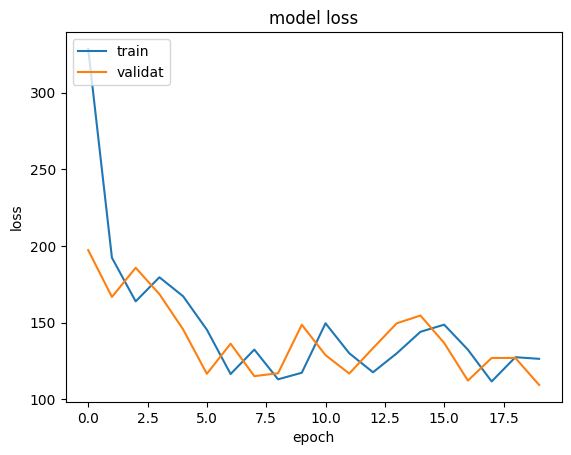

In [ ]:
model_plot(history)